In [1]:
import numpy as np
import pandas as pd

#可視化
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

from keras.models import Sequential,load_model
from keras.layers import Dense,Activation,Dropout,Conv2D,MaxPool2D,Flatten,BatchNormalization
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [2]:
#data
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

train.columns

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

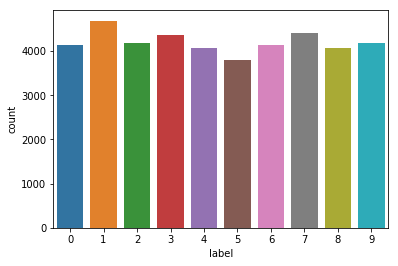

In [3]:
train_y=train['label']
train_X=train.drop(['label'],axis=1)

g=sns.countplot(train_y)
train_y.value_counts()

In [4]:
train_X=train_X.values.reshape(-1,28,28,1)
test=test.values.reshape(-1,28,28,1)

In [5]:
train_y=to_categorical(train_y,num_classes=10)

In [6]:
train_X,val_X,train_y,val_y=train_test_split(train_X,train_y,test_size=0.1,random_state=42)

In [7]:
model=Sequential()
model.add(Conv2D(input_shape=(28,28,1),filters=32,activation='relu',kernel_size=(3,3),strides=(1,1),padding='same'))
model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',strides=(1,1),padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu'))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(10,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

In [8]:
#画像の水増し
from keras.preprocessing.image import ImageDataGenerator
imggen=ImageDataGenerator(featurewise_center=False, 
                          samplewise_center=False, 
                          featurewise_std_normalization=False, 
                          samplewise_std_normalization=False, 
                          rotation_range=0.1, 
                          width_shift_range=0.1, 
                          height_shift_range=0.1, 
                          zoom_range=0.1, 
                          horizontal_flip=False, 
                          vertical_flip=False, )

In [9]:
imggen.fit(train_X)

In [10]:
history=model.fit_generator(imggen.flow(train_X,train_y,batch_size=32),epochs=15,
                           validation_data=(val_X,val_y),
                           verbose=1,steps_per_epoch=len(train_X)/32)

Epoch 1/15
1182/1181 [==============================] - 172s 145ms/step - loss: 0.2806 - acc: 0.9114 - val_loss: 0.1082 - val_acc: 0.9626
Epoch 2/15
1182/1181 [==============================] - 177s 150ms/step - loss: 0.1059 - acc: 0.9671 - val_loss: 0.0574 - val_acc: 0.9831
Epoch 3/15
1182/1181 [==============================] - 179s 151ms/step - loss: 0.0831 - acc: 0.9744 - val_loss: 0.0351 - val_acc: 0.9890
Epoch 4/15
1182/1181 [==============================] - 178s 151ms/step - loss: 0.0705 - acc: 0.9783 - val_loss: 0.0395 - val_acc: 0.9883
Epoch 5/15
1182/1181 [==============================] - 180s 152ms/step - loss: 0.0632 - acc: 0.9806 - val_loss: 0.0387 - val_acc: 0.9898
Epoch 6/15
1182/1181 [==============================] - 171s 145ms/step - loss: 0.0573 - acc: 0.9819 - val_loss: 0.0380 - val_acc: 0.9912
Epoch 7/15
1182/1181 [==============================] - 174s 147ms/step - loss: 0.0537 - acc: 0.9842 - val_loss: 0.0272 - val_acc: 0.9910
Epoch 8/15
1182/1181 [============

4200/4200 [==============================] - 4s 1ms/step
loss:0.022429418674742227
 acc :0.9930952380952381


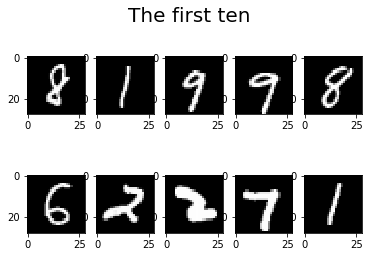

[8 1 9 9 8 6 2 2 7 1]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)         

In [11]:
score=model.evaluate(val_X,val_y,verbose=1)
print('loss:{0[0]}\n acc :{0[1]}'.format(score))

#可視化
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(val_X[i].reshape((28,28)),'gray')
    
plt.suptitle('The first ten',fontsize=20)
plt.show()

pred=np.argmax(model.predict(val_X[:10]),axis=1)
print(pred)

model.summary()

In [12]:
results=model.predict(test)
results=np.argmax(results,axis=1)
results=pd.Series(results,name='Label')

In [14]:
submission=pd.concat([pd.Series(range(1,28001),name='ImageID'),results],axis=1)
submission.to_csv('cnn_mnist_batch_normalization.csv',index=False)